<a href="https://colab.research.google.com/github/eklavya172004/Informational-Retrieval/blob/main/IR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
#Upload Corpus File
from google.colab import files
import os

try:
    os.makedirs('./Corpus', exist_ok=True)
    print("Created Corpus directory")
    print("Please select your corpus files to upload:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        source_path = filename
        dest_path = f'./Corpus/{filename}'
        os.rename(source_path, dest_path)
        print(f"Moved {filename} to Corpus directory")

    print(f"Successfully uploaded {len(uploaded)} files to ./Corpus/")

except Exception as e:
    print(f"Error: {e}")

corpus_dir = './Corpus'

Created Corpus directory
Please select your corpus files to upload:


Saving Corpus-20230203T210935Z-001.zip to Corpus-20230203T210935Z-001.zip
Moved Corpus-20230203T210935Z-001.zip to Corpus directory
Successfully uploaded 1 files to ./Corpus/


In [33]:
#extract files from zip
import zipfile
import os

zip_path = './Corpus/Corpus-20230203T210935Z-001.zip'
extract_path = './Corpus/extracted/'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print("ZIP file extracted successfully!")

print("Extracted files:")
for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(os.path.join(root, file))

corpus_dir = extract_path

ZIP file extracted successfully!
Extracted files:
./Corpus/extracted/Corpus/shakespeare.txt
./Corpus/extracted/Corpus/reddit.txt
./Corpus/extracted/Corpus/Amazon.txt
./Corpus/extracted/Corpus/zomato.txt
./Corpus/extracted/Corpus/volkswagen.txt
./Corpus/extracted/Corpus/spotify.txt
./Corpus/extracted/Corpus/Lenovo.txt
./Corpus/extracted/Corpus/canva.txt
./Corpus/extracted/Corpus/reliance.txt
./Corpus/extracted/Corpus/whatsapp.txt
./Corpus/extracted/Corpus/Ola.txt
./Corpus/extracted/Corpus/microsoft.txt
./Corpus/extracted/Corpus/paypal.txt
./Corpus/extracted/Corpus/youtube.txt
./Corpus/extracted/Corpus/sony.txt
./Corpus/extracted/Corpus/blackberry.txt
./Corpus/extracted/Corpus/yahoo.txt
./Corpus/extracted/Corpus/samsung.txt
./Corpus/extracted/Corpus/puma.txt
./Corpus/extracted/Corpus/instagram.txt
./Corpus/extracted/Corpus/steam.txt
./Corpus/extracted/Corpus/swiggy.txt
./Corpus/extracted/Corpus/levis.txt
./Corpus/extracted/Corpus/nokia.txt
./Corpus/extracted/Corpus/google.txt
./Corpus/ex

In [34]:
import os
import math
import re
from collections import defaultdict, Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

#Text Pre-processing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    words = text.strip().split()
    processed = [stemmer.stem(w) for w in words if w not in stop_words]
    return " ".join(processed)

#Load Documents
def load_documents(corpus_dir):
    documents = {}
    encodings_to_try = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']

    for root, dirs, files in os.walk(corpus_dir):
        for filename in files:
            file_path = os.path.join(root, filename)
            doc_id, ext = os.path.splitext(filename)

            if os.path.isdir(file_path):
                continue
            if ext.lower() not in ['.txt', '.text', '']:
                continue

            content = None
            for encoding in encodings_to_try:
                try:
                    with open(file_path, 'r', encoding=encoding) as file:
                        content = file.read()
                    break
                except:
                    continue

            if content is not None and content.strip():
                documents[doc_id] = preprocess_text(content)

    return documents

#TF-IDF Calculations
def calculate_idf(documents):
    idf = {}
    df = defaultdict(int)
    total_docs = len(documents)

    for text in documents.values():
        terms = set(text.split())
        for term in terms:
            df[term] += 1

    for term, freq in df.items():
        idf[term] = math.log10(total_docs / freq)

    return idf, df

def calculate_document_vectors(documents): #normalized TF vectors for each document
    doc_vectors = defaultdict(dict)
    for doc_id, text in documents.items():
        term_freq = Counter(text.split())
        for term, freq in term_freq.items():
            doc_vectors[doc_id][term] = 1 + math.log10(freq)

        norm = math.sqrt(sum(weight ** 2 for weight in doc_vectors[doc_id].values()))
        if norm > 0:
            for term in doc_vectors[doc_id]:
                doc_vectors[doc_id][term] /= norm

    return doc_vectors

#Query Processing
def build_query_vector(query, idf):
    query_terms = Counter(query.split())
    query_vector = {}
    for term, freq in query_terms.items():
        if freq > 0:
            tf = 1 + math.log10(freq)
            query_vector[term] = tf * idf.get(term, 0)
    norm = math.sqrt(sum(weight ** 2 for weight in query_vector.values()))
    if norm > 0:
        for term in query_vector:
            query_vector[term] /= norm
    return query_vector

#Posting File
def write_postings_to_file(df, documents):
    with open("posting.txt", "w") as f:
        for term, freq in df.items():
            f.write(f"Term: {term}\n")
            f.write(f"Document Frequency (df): {freq}\n")
            f.write("Posting List:\n")
            for doc_id, text in documents.items():
                term_freq = Counter(text.split())
                if term in term_freq:
                    f.write(f"  ({doc_id}, {term_freq[term]})\n")
            f.write("\n")

#Cosine Similarity
def cosine_similarity(query_vector, doc_vector):
    numerator = sum(query_vector.get(term, 0) * doc_vector.get(term, 0) for term in query_vector)
    query_norm = math.sqrt(sum(v ** 2 for v in query_vector.values()))
    doc_norm = math.sqrt(sum(v ** 2 for v in doc_vector.values()))
    return numerator / (query_norm * doc_norm) if query_norm and doc_norm else 0

#Soundex Functions
def soundex(word):
    word = word.upper()
    soundex_code = word[0]
    mapping = {"BFPV": "1", "CGJKQSXZ": "2", "DT": "3", "L": "4",
               "MN": "5", "R": "6"}

    def get_digit(char):
        for key in mapping:
            if char in key:
                return mapping[key]
        return "0"

    prev_digit = ""
    for char in word[1:]:
        digit = get_digit(char)
        if digit != "0" and digit != prev_digit:
            soundex_code += digit
        prev_digit = digit

    soundex_code = soundex_code.ljust(4, "0")[:4]
    return soundex_code

def apply_soundex_names(query_terms, name_list):#match query terms with names
    matched_terms = []
    name_codes = {name: soundex(name) for name in name_list}
    for term in query_terms:
        term_code = soundex(term)
        for name, code in name_codes.items():
            if term_code == code:
                matched_terms.append(name)
                break
    return matched_terms

proper_names = ["ridhima", "adnan", "alex", "robert"]

#Document Ranking
def rank_documents(query, doc_vectors, idf, vocabulary):
    query = preprocess_text(query)
    query_terms = query.split()

    exact_terms = [term for term in query_terms if term in vocabulary]

    name_terms = apply_soundex_names(query_terms, proper_names)

    valid_terms = list(set(exact_terms + name_terms))
    if not valid_terms:
        return []

    query = " ".join(valid_terms)
    query_vector = build_query_vector(query, idf)
    if all(weight == 0 for weight in query_vector.values()):
        return []

    scores = []
    for doc_id, doc_vector in doc_vectors.items():
        score = cosine_similarity(query_vector, doc_vector)
        if score > 0:
            scores.append((doc_id, score))

    scores.sort(key=lambda x: (-x[1], x[0]))
    return scores[:10]

#Main Execution
print("Loading documents...")
corpus_dir = './Corpus/'
documents = load_documents(corpus_dir)
print(f"Loaded {len(documents)} documents.")

idf, df = calculate_idf(documents)
doc_vectors = calculate_document_vectors(documents)
write_postings_to_file(df, documents)

vocabulary = df.keys()

print("Search system ready!")
print("=" * 50)

while True:
    query = input("Enter your search query (or type 'exit' to quit): ")
    if query.lower() == 'exit':
        break
    ranked_docs = rank_documents(query, doc_vectors, idf, vocabulary)
    if not ranked_docs:
        print("No matching documents found.")
    else:
        print("Ranked Documents:")
        for doc_id, score in ranked_docs:
            print(f"Document ID: {doc_id}, Score: {score:.4f}")
    print("-" * 30)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading documents...
Loaded 41 documents.
Search system ready!
Enter your search query (or type 'exit' to quit): tech
Ranked Documents:
Document ID: canva, Score: 0.0743
Document ID: Ola, Score: 0.0697
Document ID: yahoo, Score: 0.0597
Document ID: skype, Score: 0.0574
------------------------------
Enter your search query (or type 'exit' to quit): information
Ranked Documents:
Document ID: nokia, Score: 0.0772
Document ID: messenger, Score: 0.0764
Document ID: bing, Score: 0.0747
Document ID: zomato, Score: 0.0673
Document ID: samsung, Score: 0.0606
Document ID: whatsapp, Score: 0.0606
Document ID: Dell, Score: 0.0602
Document ID: yahoo, Score: 0.0597
Document ID: spotify, Score: 0.0588
Document ID: telegram, Score: 0.0542
------------------------------
Enter your search query (or type 'exit' to quit): Developing your Zomato business account and profile is a great way to boost your restaurant’s online reputation
Ranked Documents:
Document ID: zomato, Score: 0.2147
Document ID: swiggy,

In [35]:
#Highlight Query Matches
def highlight_matches(doc_text, query_terms, snippet_length=30):
    words = doc_text.split()
    highlighted_snippets = []

    query_set = set(query_terms)

    for i, word in enumerate(words):
        if word in query_set:
            start = max(i - snippet_length, 0)
            end = min(i + snippet_length + 1, len(words))
            snippet = words[start:end]

            snippet = ["**" + w + "**" if w in query_set else w for w in snippet]
            highlighted_snippets.append(" ".join(snippet))

    return " ... ".join(highlighted_snippets[:3])

#Example Usage
query = "Levi Strauss"
query_terms = [w.lower() for w in query.strip().split()]

for doc_id, text in documents.items():
    snippet = highlight_matches(text, query_terms, snippet_length=20)
    if snippet:
        print(f"Document ID: {doc_id}")
        print(f"Snippet: {snippet}")
        print("-" * 50)


Document ID: microsoft
Snippet: court overturn breakup order still found compani guilti illeg tri maintain monopoli compani legal woe continu 2004 european union eu **levi** largest fine organ histori point 497 2 million 611 million retali describ microsoft near monopoli practic februari 2008 eu impos
--------------------------------------------------
Document ID: levis
Snippet: **levi** walter haa born may 11 1889 san francisco calif u die dec 7 1979 san francisco american busi execut credit ... born may 11 1889 san francisco calif u die dec 7 1979 san francisco american busi execut credit save founder **levi** **strauss** co major manufactur blue jean denim pant haa effort world war ii laid groundwork compani dramat growth blue jean ... may 11 1889 san francisco calif u die dec 7 1979 san francisco american busi execut credit save founder **levi** **strauss** co major manufactur blue jean denim pant haa effort world war ii laid groundwork compani dramat growth blue jean boom
--------

In [36]:
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')

#Synonym Extraction
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ').lower()
            if synonym != word.lower():
                synonyms.add(synonym)
    return synonyms

#Query Expansion Function
def expand_query_with_synonyms(query, max_synonyms_per_word=3):
    query_terms = query.strip().split()
    expanded_terms = list(query_terms)

    for term in query_terms:
        synonyms = list(get_synonyms(term))[:max_synonyms_per_word]
        expanded_terms.extend(synonyms)

    return list(set(expanded_terms))

#Example Usage
query = "food"
expanded_query_terms = expand_query_with_synonyms(query)
print("Original Query:", query)
print("Expanded Query:", expanded_query_terms)


Original Query: food
Expanded Query: ['solid food', 'nutrient', 'intellectual nourishment', 'food']


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


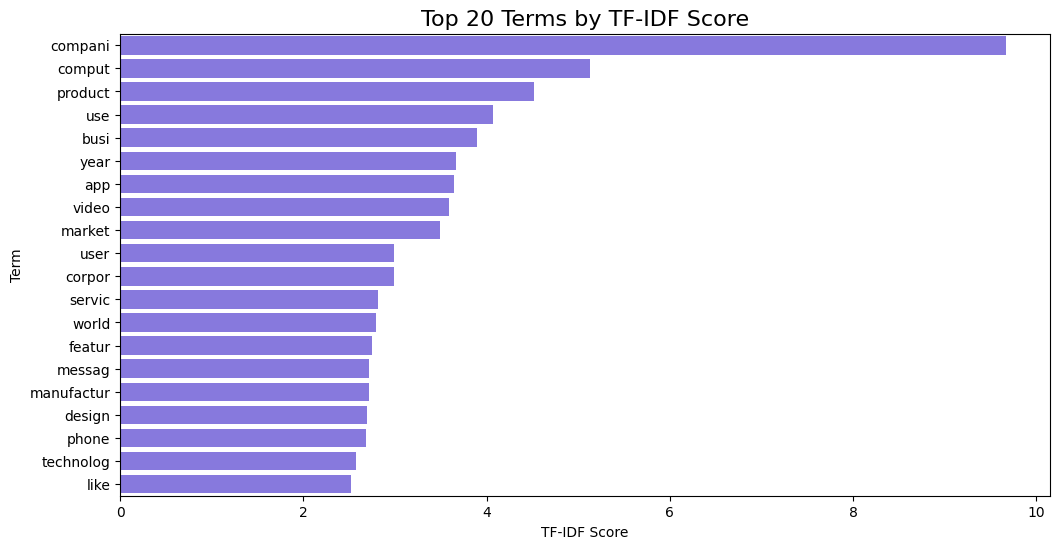

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

doc_texts = list(documents.values())

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=50)
X = vectorizer.fit_transform(doc_texts)
terms = vectorizer.get_feature_names_out()
tfidf_scores = X.toarray().sum(axis=0)  # sum TF-IDF

# Top 20 terms
top_terms = dict(sorted(zip(terms, tfidf_scores), key=lambda x: x[1], reverse=True)[:20])
df = pd.DataFrame(list(top_terms.items()), columns=['Term', 'TF-IDF'])

plt.figure(figsize=(12, 6))
sns.barplot(x='TF-IDF', y='Term', data=df, color='mediumslateblue')
plt.title("Top 20 Terms by TF-IDF Score", fontsize=16)
plt.xlabel("TF-IDF Score")
plt.ylabel("Term")
plt.show()
